## Setup

In [ ]:
print("Installing")
!pip install transformers --quiet
!pip install peft --quiet
!pip install tensorflow --quiet
!pip install nltk --quiet
!pip install datasets --quiet
!pip install rouge-score --quiet
!pip install -q -U bitsandbytes
!pip install -q trl
print("Finished")

Installing
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 9.1 MB/s eta 0:00:00
Finished


In [3]:
from huggingface_hub import login
from google.colab import drive

# input hugginface token here
login(token="")
drive.mount('/content/drive')


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Mounted at /content/drive


In [ ]:
import torch
from peft import LoraConfig, PeftModel, PeftConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import (AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig,
                          AutoModelForSeq2SeqLM, AutoTokenizer, BartForConditionalGeneration,
                          BartTokenizer)

import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Jokes

In [ ]:
joke_headers = ["Why didn't 4 ask out 5?",
                "How do you know when your girlfriend is getting fat?",
                "Why did the police raid the elementary school?",
                "Did you hear about how my East Asian plant collection was actually fake?",
                "Why did Jesus quit being a carpenter?",
                "How can you tell that someone's a farmer?",
                "Did you hear about the Italian who broke both of his arms?",
                "Why do you call a handy man without any hands?",
                "How many police officers does it take to change a lightbulb?",
                "How do you kill a hippie?",
                "What's orange and sounds like a parrot?",
                "How does a computer get drunk?",
                "What's a pirate's favorite letter?",
                "What's the difference between snowmen and snowwomen?",
                "What does DNA stand for?",
                "Why did the old lady fall down the watering hole?",
                "Why was the mime sentenced to life in prison?",
                "Why do we call table that feels good to sit on",
                "Why did the chicken cross the road?",
                "Why was 6 afraid of 7?",
                "What was the lazy Russian man's name?",
                "What's the difference between prostitutes and Jesus?",
                "I couldn't figure out how to throw a boomerange.",
                "How high are you?",
                "How many lawyers does it take to screw in a lightbulb?",
                "Want to hear an icebreaker?",
                "I invented a new word today!",
                "Why does the homeless man drink coffee?",
                "I walked into a bar.",
                "What do you call bears without ears?"]

print(len(joke_headers))

30


## Load Mistral, T5, Bart

In [ ]:
dir = '/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/Mistral-7B-Instruct-v0.1v1'

bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.bfloat16,
    bnb_4bit_use_double_quant= False,
)

device = torch.device("cuda")
mistral = AutoModelForCausalLM.from_pretrained(dir, quantization_config=bnb_config)

mistral_tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-Instruct-v0.1', trust_remote_code=True,
                                          padding_side='left')
mistral_tokenizer.pad_token = mistral_tokenizer.eos_token
mistral_tokenizer.add_eos_token = True
mistral_tokenizer.add_bos_token, mistral_tokenizer.add_eos_token

mistral = PeftModel.from_pretrained(mistral, dir, device_map={"":0})
mistral.eval()

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PeftModel(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit

In [ ]:
dir = '/content/drive/MyDrive/Models/google/flan-t5-basev3/checkpoint-1400'
# Load peft config for pre-trained checkpoint etc.
config = PeftConfig.from_pretrained(dir)

# load base LLM model and tokenizer
t5 = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path,  device_map={"":0})
t5_tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
t5 = PeftModel.from_pretrained(t5, dir, device_map={"":0})
t5.eval()

print("Peft model loaded")


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Peft model loaded


In [ ]:
dir = '/content/drive/MyDrive/Models/facebook/bart-basev3/checkpoint-1400'

bart = BartForConditionalGeneration.from_pretrained(dir)
bart_tokenizer = BartTokenizer.from_pretrained(dir)

# Load peft config for pre-trained checkpoint etc.
config = PeftConfig.from_pretrained(dir)

# Load the Lora model
bart = PeftModel.from_pretrained(bart, dir, device_map={"":0})
bart = bart.to(device)
bart.eval()

print("Peft model loaded")

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Peft model loaded


## Generate Punchlines

In [ ]:
def stream(user_prompt):
    runtimeFlag = "cuda:0"
    system_prompt = 'You are a bot that responds to jokes with comedic punchlines \n'
    B_INST, E_INST = "[INST]", "[/INST]"

    prompt = f"{system_prompt}{B_INST}{user_prompt.strip()}\n{E_INST}"

    inputs = mistral_tokenizer([prompt], return_tensors="pt").to(runtimeFlag)

    output = mistral.generate(**inputs, max_new_tokens=50)
    text = mistral_tokenizer.decode(output[0], skip_special_tokens=True)

    # Find the position of [/INST]
    end_inst_position = text.find("[/INST]") + len("[/INST]")

    # Find the first period after [/INST]
    period_position = text.find(".", end_inst_position)

    # Extract the string between [/INST] and the first period
    if period_position > -1:
        extracted_text = text[end_inst_position:period_position].strip()
    else:
        extracted_text = text[end_inst_position:].strip()  # If no period, take everything after [/INST]

    return extracted_text

In [ ]:
def t5_generate(joke):
    prompt = "Finish the joke: "
    encoded_prompt = t5_tokenizer.encode_plus(
                prompt + joke, add_special_tokens = True, truncation = True,
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')

    # Move data to device
    input_ids = encoded_prompt['input_ids'].to(device)
    attention_masks = encoded_prompt['attention_mask'].to(device)

    outs = t5.generate(input_ids=input_ids, attention_mask=attention_masks,
                          max_length=256, temperature=0.97, do_sample=True)
    ans = t5_tokenizer.decode(outs[0], skip_special_tokens=True)

    return ans

In [ ]:
def bart_generate(joke):
    prompt = "Generate a funny punchline for this joke: "
    encoded_prompt = bart_tokenizer.encode_plus(
                prompt + joke, add_special_tokens = True, truncation = True,
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')

    # Move data to device
    input_ids = encoded_prompt['input_ids'].to(device)
    attention_masks = encoded_prompt['attention_mask'].to(device)

    outs = bart.generate(input_ids=input_ids, attention_mask=attention_masks,
                          max_length=256, temperature=0.97, do_sample=True,
                          num_beams=4)
    ans = bart_tokenizer.decode(outs[0], skip_special_tokens=True)

    return ans

In [ ]:
mistral_jokes = []
t5_jokes = []
bart_jokes = []

for i in joke_headers:
    mistral_jokes.append(stream(i))
    t5_jokes.append(t5_generate(i))
    bart_jokes.append(bart_generate(i))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token

In [ ]:
df = pd.DataFrame({
    'Header': joke_headers,
    'A': mistral_jokes,
    'B': t5_jokes,
    'C': bart_jokes
})

df['Answers'] = np.nan

In [ ]:
df.head()

,Header,A,B,C,Answers
0,Why didn't 4 ask out 5?,Because 5 was married,Because he just ached the last of his shit fro...,"If you think about it, it's a total waste of t...",NaN
1,How do you know when your girlfriend is gettin...,She fits in your wife's clothes,She gets fat.,I am not a very good businessman.But I am a go...,NaN
2,Why did the police raid the elementary school?,They heard there were some small children in t...,Because they'll come up with a new school.,I can't believe it!,NaN
3,Did you hear about how my East Asian plant col...,It was a façade,It was actually just a garden.,They have a lot of room.,NaN
4,Why did Jesus quit being a carpenter?,He got nailed on the job,He was ashamed of himself!,But I'm not going to waste my time.,NaN


In [ ]:
df.to_csv('/content/drive/MyDrive/Models/human_eval.csv', index=False)

## Getting Training Losses

In [4]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [5]:
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [6]:
logdirs = ["/content/drive/MyDrive/Models/google/flan-t5-basev3/runs/Apr13_01-36-02_dea8c2bc928c/events.out.tfevents.1712972178.dea8c2bc928c.3341.6",
           "/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/runs/Apr16_21-25-43_181ca75ce4c9",
           "/content/drive/MyDrive/Models/facebook/bart-basev3/runs/Apr15_07-50-55_c7ee5f7ccb67"]

In [7]:
dfs = []
for i, log in enumerate(logdirs):
    df = tflog2pandas(log)  # Convert log to DataFrame
    dfs.append(df)  # Store each DataFrame in the list

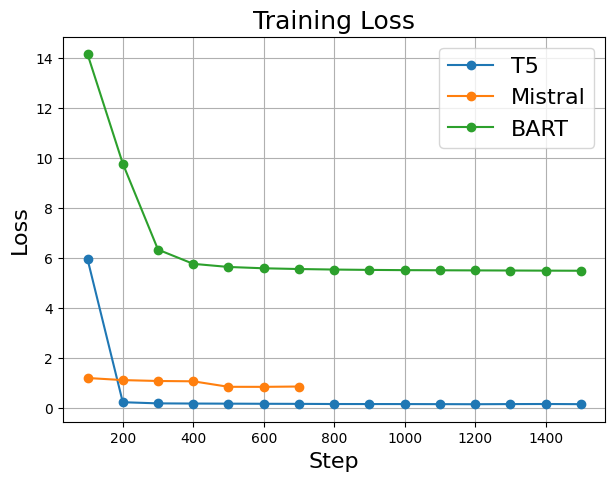

In [22]:
import matplotlib.pyplot as plt

model_names = ["T5", "Mistral", "BART"]
plt.figure(figsize=(7, 5))
i = 0
for df in dfs:
    # Filter the DataFrame by metric
    train_loss_df = df[df['metric'] == 'train/loss']
    # Plot loss
    plt.plot(train_loss_df['step'], train_loss_df['value'], marker='o', label=model_names[i])
    i += 1

plt.xlabel('Step', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training Loss', fontsize=18)
plt.grid(True)
plt.legend(fontsize=16)

pdf_filename = "line_plot.pdf"  # Define the filename
plt.savefig(pdf_filename, format='pdf')  # Save as a PDF

# Display the plot (optional)
plt.show()

<Figure size 640x480 with 0 Axes>